# Pathway Evaluation
The goal is to analyse the behaviour of the different pathway when they are fed with the chosen substrate Methanol. They are judged by their maximum production and the maximum MA flux in relation to the biomass growth rate.

### Loading model and defining medium
This is only loading the basis model and adding NAM, NA and NR to the medium, aswell as defining their maximum optake rates. It spits out a Table to visualize the media composition.

In [3]:
# Importing used packages and model
from cobra.io import read_sbml_model
from cobra import Reaction, Metabolite
import pandas as pd
import matplotlib.pyplot as plt

model = read_sbml_model('iML1515.xml')
%run -i create_pathway.ipynb
# flux unit is mmol / [gDW h]

#Defining media
model.add_boundary(model.metabolites.get_by_id("ncam_e"), type="exchange")
model.add_boundary(model.metabolites.get_by_id("nr_e"), type="exchange")
model.add_boundary(model.metabolites.get_by_id("na_e"), type="exchange")

#Choosing uptake rates
medium=model.medium
medium['EX_ncam_e'] = 100
medium['EX_nr_e'] = 100
medium["EX_na_e"] = 100
medium["EX_glc__D_e"] = 10
print('Table 2: Medium composition')
# create a data frame to plot a table
med_names = dict()
for flux in medium:
    meta = model.reactions.get_by_id(flux).metabolites
    for element in meta:
        med_names[flux] = element.name
df_med = pd.DataFrame(medium, index=['uptake'])
df_names = pd.DataFrame(med_names, index=['name'])
display(pd.concat([df_names,df_med]))

OSError: The file with 'iML1515.xml' does not exist, or is not an SBML string. Provide the path to an existing SBML file or a valid SBML string representation:


### Creating the 3 differint routes/pathways
When the pathways need to be used, they should be called as nam_model, na_model or nr_model. This should be put in instead of the normal code where it only says "model".

In [2]:
# creating the models with the respective pathways

# path_selector legend
# 0 -> no additional reactions
#1 -> nicotinamid pathway  
#2 -> nicotinic acid pathway  
#3 -> nicotinamid riboside pathway

nam_model = create_pathway(model.copy(),1)
na_model = create_pathway(model.copy(),2)
nr_model = create_pathway(model.copy(),3)
models = [model, (nam_model,'NAMPT'),(na_model,'NMN Synthetase'),(nr_model,'DeoD')]
'done'

'done'

### Testing for biomass and NMN production
The different cells are just different attempts of running an FBA basically.

In [3]:
with nam_model:
    growth = nam_model.optimize()
    max_growth_rate = growth.fluxes['BIOMASS_Ec_iML1515_core_75p37M']
    print(max_growth_rate)
    
    print(growth)

1.384569944094851
<Solution 1.385 at 0x28aafdf2c40>


In [4]:
max_growth_rate

1.384569944094851

In [5]:
# Run double optimization, both biomass and product.
with nam_model:
    
    # Objective set to NMN
    nam_model.objective = nam_model.reactions.BMpnuC
    solution = nam_model.optimize()
    
    # Objective set to Biomass
    nam_model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound=0.10
    nam_model.objective = nam_model.reactions.BIOMASS_Ec_iML1515_core_75p37M
    growth = nam_model.optimize().objective_value
    
    print('Max. NMN secretion [mmol gDW^-1 h^-1]:', solution.fluxes['BMpnuC'])
    print(nam_model.optimize().fluxes['BIOMASS_Ec_iML1515_core_75p37M'])


Max. NMN secretion [mmol gDW^-1 h^-1]: 1000.0
1.3845699440948516


In [6]:
# Run double optimization, both biomass and product.
with nam_model:
    
    # Objective set to NMN
    nam_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M.lower_bound=0.01
    nam_model.objective = nam_model.reactions.NAMPT
    solution = nam_model.optimize()
    
    # Objective set to Biomass
    # nam_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M.lower_bound=0.01
    # nam_model.objective = nam_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M
    growth = nam_model.optimize().objective_value
    
    print('Max. NMN secretion [mmol gDW^-1 h^-1]:', solution.fluxes['NAMPT'])
    print(nam_model.optimize().fluxes['BIOMASS_Ec_iML1515_core_75p37M'])


C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Max. NMN secretion [mmol gDW^-1 h^-1]: 0.003154181169579695
1.3746229892770476


C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [7]:
with nam_model:
    nam_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M.lower_bound=10
    solution = nam_model.optimize()
    print('Max. NMN secretion [mmol gDW^-1 h^-1]:', solution.fluxes['BMpnuC'])
    print('Biomass [mmol gDW^-1 h^-1]:', nam_model.optimize().fluxes['BIOMASS_Ec_iML1515_WT_75p37M'])


C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


Max. NMN secretion [mmol gDW^-1 h^-1]: 1000.0
Biomass [mmol gDW^-1 h^-1]: 10.0


C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [8]:

with na_model:
    na_model.reactions.NMNDA.knock_out() #knockout of the pncC gene reaction.
    na_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M.lower_bound=500
    na_model.objective = na_model.reactions.BMpnuC
    solution = na_model.optimize()
    print('Max. NMN secretion [mmol gDW^-1 h^-1]:', solution.fluxes['BMpnuC'])
    print(na_model.optimize().fluxes['BIOMASS_Ec_iML1515_WT_75p37M'])


Max. NMN secretion [mmol gDW^-1 h^-1]: 0.0
500.0


C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [9]:
with nr_model:
    nr_model.reactions.NMNAT.knock_out() #knockout of the nadR gene reaction.
    nr_model.reactions.BIOMASS_Ec_iML1515_WT_75p37M.lower_bound=0.5
    nr_model.obective=nr_model.reactions.BMpnuC
    print(nr_model.optimize().objective_value)
    print(nr_model.optimize().fluxes['BIOMASS_Ec_iML1515_WT_75p37M'])


0.0
0.5


C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Aljosha\anaconda3\lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


## Simulating pathways and visualizing results (just ignore for now)
The pathways are one by one simulated with the set medium flux. They are analyzed for maximum NMN production in relation to the biomass growth. The phenotypic phase planes show the relation of the carbon yield for malonic acid on methanol as a function of the growth rate.

### FSEOF + phase plane code and figures
Marc should know what to do

In [13]:
from cameo import models
from cameo.visualization.plotting.with_plotly import PlotlyPlotter

In [14]:
plotter = PlotlyPlotter()


In [16]:
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
fseof = FSEOF(nam_model)
result=fseof.run(target=nam_model.reactions.NAMPT)

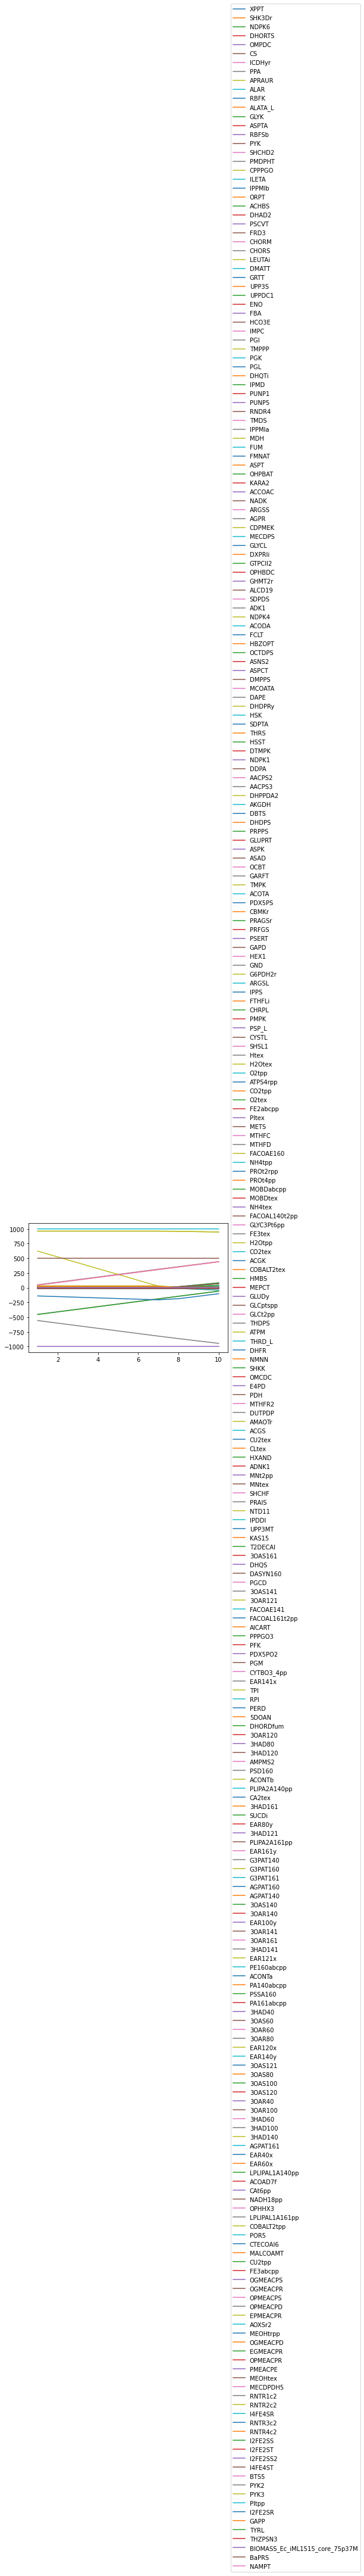

In [17]:
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor = (1, 0.5))
plt.show()

In [ ]:
from cameo.flux_analysis.analysis import phenotypic_phase_plane
from cameo.strain_design.deterministic import DifferentialFVA

In [ ]:
production_envelope = phenotypic_phase_plane(nam_model,
                                             variables=[nam_model.reactions.BMpnuC],
                                             objective=nam_model.metabolites.ncam_c)
production_envelope.plot(plotter, height=400)